- hacim tahminleme
    - klasik model
        - diğer featurelar
                - ek veri
                    - enflasyon
                    - döviz
                    - üfe
                    - holiday dataset
          
                - order day/week/month
                - sipariş verme sıklığı
                - daily_average
                - ürün bazlı sipariş verme sıklığı
                - day diff between last order
    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi
    - rnn
    - lstm

trials
    - sum of past data
    - average of past data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
order_df = pd.read_csv('data/datathon_order.csv', parse_dates=['Sipariş Tarihi'], 
                       usecols=['Malzeme Numarası', 'Sipariş Edilen Miktar','Müşteri No', 'Sipariş Tarihi'])

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
order_df.columns

Index(['Malzeme Numarası', 'Sipariş Edilen Miktar', 'Müşteri No',
       'Sipariş Tarihi'],
      dtype='object')

In [4]:
order_df.columns = ['material_num', 'order_amount', 'customer_num', 'order_date']

In [5]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [6]:
order_df.head()

,material_num,order_amount,customer_num,order_date
0,61001960,60,C-10008,2020-01-02
1,61000066,25,C-10185,2020-01-02
2,61001960,50,C-10185,2020-01-02
3,61000066,40,C-10188,2020-01-02
4,61001960,20,C-10188,2020-01-02


In [7]:
# from analysis we saw that customer number 'C-10170' is replaced with 'C-10277', so we replace all the values
order_df.replace('C-10170', 'C-10277', inplace=True)

In [8]:
order_df.isna().sum()

material_num    0
order_amount    0
customer_num    0
order_date      0
dtype: int64

In [9]:
for col in order_df.columns:
    print(f'# of unique values in {col} : {order_df[col].nunique()}')

# of unique values in material_num : 807
# of unique values in order_amount : 1243
# of unique values in customer_num : 670
# of unique values in order_date : 319


In [10]:
order_df.describe()

,order_amount
count,508069.000000
mean,29.491608
std,118.890148
min,1.000000
25%,2.000000
50%,5.000000
75%,20.000000
max,21000.000000


In [11]:
raw_df = order_df.copy()

In [12]:
order_df['order_week'] = order_df['order_date'].dt.week

<ipython-input-12-6e1589c49ef7>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  order_df['order_week'] = order_df['order_date'].dt.week


In [13]:
order_df.shape

(508069, 5)

<AxesSubplot:>

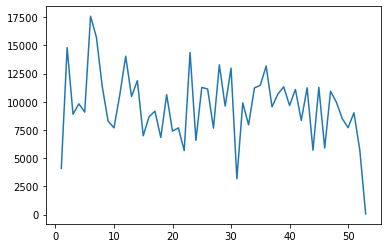

In [14]:
order_df['order_week'].value_counts().sort_index().plot()

In [15]:
# grouping data by order_date, same products may be placed with different orders in same day
order_df = order_df.groupby(['order_week', 'material_num', 'customer_num'])['order_amount'].sum().reset_index()

In [16]:
order_df.shape

(347616, 4)

In [17]:
dates20 = pd.DataFrame(order_df['order_week'].unique(), columns=['order_week'])
materials = pd.DataFrame(order_df['material_num'].unique(), columns=['material_num'])
customers = pd.DataFrame(order_df['customer_num'].unique(), columns=['customer_num'])
dates20['key'] = 1
materials['key'] = 1
customers['key'] = 1
null_df = pd.merge(dates20, materials, on=['key'], how='left')
null_df = pd.merge(null_df, customers, on=['key'], how='left')
null_df.drop('key', axis=1, inplace=True)

In [18]:
order_df = pd.merge(null_df, order_df, on=['order_week', 'material_num', 'customer_num'], how='left')

In [19]:
order_df.head()

,order_week,material_num,customer_num,order_amount
0,1,91704,M10125,2.0
1,1,91704,M10140,21.0
2,1,91704,M10142,13.0
3,1,91704,M10143,12.0
4,1,91704,M10158,4.0


In [20]:
order_df.isna().sum()/order_df.shape[0]

order_week      0.00000
material_num    0.00000
customer_num    0.00000
order_amount    0.98787
dtype: float64

In [21]:
order_df.fillna(0.0, inplace=True)

In [22]:
order_df.dtypes

order_week        int64
material_num     object
customer_num     object
order_amount    float64
dtype: object

In [23]:
order_df['material_num'] = order_df['material_num'].astype('str')
order_df['order_amount'] = order_df['order_amount'].astype('int32')
order_df['customer_num'] = order_df['customer_num'].astype('str')
order_df['order_week'] = order_df['order_week'].astype('int16')

In [24]:
order_df.dtypes

order_week       int16
material_num    object
customer_num    object
order_amount     int32
dtype: object

In [25]:
order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10)

material_num
4016984     458685
61001960    368298
4002326     352764
4002329     344800
4047491     228728
TR01822B    222226
TR01575A    203860
4050584     195385
PL08105A    189395
TR02288A    172344
Name: order_amount, dtype: int32

In [26]:
order_df.groupby(['material_num'])['order_amount'].sum().nsmallest(10)

material_num
4253047     1
669690      1
669719      1
CN00912A    1
PL03154A    1
TR00191B    1
TR01657A    1
TR01659A    1
4253046     2
61008454    2
Name: order_amount, dtype: int32

when we analyze the daily total sales, dataset looks like stationary whihch does not have any trend or seasonality

p value is less than 0.05 we reject the H0 hypothesis, meaning our data is stationary

### ürün ve müşteri bazlı geçmiş 1,2,3,5,7,14,30 haftalık toplam/ortalama siparişler

In [27]:
order_df.shape

(28656570, 4)

In [28]:
# customer-product economy
for i in range(1,15):
    order_df['shift'+str(i)] = order_df.groupby(['material_num', 'customer_num'])['order_amount'].shift(i)

In [29]:
# product economy
prod_df = order_df.groupby(['order_week', 'material_num'])['order_amount'].sum().reset_index()

for i in range(1,15):
    prod_df['shift'+str(i)] = prod_df.groupby(['material_num'])['order_amount'].shift(i)

In [30]:
# customer economy
cust_df = order_df.groupby(['order_week', 'customer_num'])['order_amount'].sum().reset_index()

for i in range(1,15):
    cust_df['shift'+str(i)] = cust_df.groupby(['customer_num'])['order_amount'].shift(i)

In [31]:
# whole economy
whole_df = order_df.groupby(['order_week'])['order_amount'].sum().reset_index()

for i in range(1,15):
    whole_df['shift'+str(i)] = whole_df['order_amount'].shift(i)

In [32]:
order_df.fillna(0.0, inplace=True)
prod_df.fillna(0.0, inplace=True)
cust_df.fillna(0.0, inplace=True)
whole_df.fillna(0.0, inplace=True)

In [33]:
order_df.head()

,order_week,material_num,customer_num,order_amount,shift1,shift2,shift3,shift4,shift5,shift6,shift7,shift8,shift9,shift10,shift11,shift12,shift13,shift14
0,1,91704,M10125,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,91704,M10140,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,91704,M10142,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,91704,M10143,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,91704,M10158,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
sum_cols = {}

for num_week in [2, 3, 4, 5, 7, 10, 14]:
    
    week_cols = []
    
    for i in range(1,1+num_week):
        
        week_cols.append('shift'+str(i))
    sum_cols['sum'+str(num_week)] = week_cols   

In [35]:
for col_name, cols_to_sum in sum_cols.items():
    
    order_df['order_'+col_name] = order_df[cols_to_sum].sum(axis=1)

In [36]:
for col_name, cols_to_sum in sum_cols.items():
    
    prod_df['prod_'+col_name] = prod_df[cols_to_sum].sum(axis=1)

In [37]:
for col_name, cols_to_sum in sum_cols.items():
    
    cust_df['cust_'+col_name] = cust_df[cols_to_sum].sum(axis=1)

In [38]:
for col_name, cols_to_sum in sum_cols.items():
    
    whole_df['whole_'+col_name] = whole_df[cols_to_sum].sum(axis=1)

In [40]:
cols_to_drop = ['shift1', 'shift2', 'shift3', 'shift4', 'shift5', 'shift6', 'shift7', 
                'shift8', 'shift9', 'shift10', 'shift11', 'shift12', 'shift13', 'shift14']

In [41]:
order_df.drop(cols_to_drop, axis=1, inplace=True)
prod_df.drop(cols_to_drop+['order_amount'], axis=1, inplace=True)
cust_df.drop(cols_to_drop+['order_amount'], axis=1, inplace=True)
whole_df.drop(cols_to_drop+['order_amount'], axis=1, inplace=True)

In [42]:
order_df = pd.merge(order_df, cust_df, 
                    on=['order_week', 'customer_num'], how='left')
order_df = pd.merge(order_df, prod_df, 
                    on=['order_week', 'material_num'], how='left')
order_df = pd.merge(order_df, whole_df, 
                    on=['order_week'], how='left')

In [51]:
order_df.head()

,order_week,material_num,customer_num,order_amount,order_sum2,order_sum3,order_sum4,order_sum5,order_sum7,order_sum10,...,prod_sum7,prod_sum10,prod_sum14,whole_sum2,whole_sum3,whole_sum4,whole_sum5,whole_sum7,whole_sum10,whole_sum14
0,1,91704,M10125,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,91704,M10140,21,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,91704,M10142,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,91704,M10143,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,91704,M10158,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
for col in order_df.select_dtypes('float').columns:
    order_df[col] = order_df[col].astype('int32')

In [63]:
order_df.dtypes

order_week       int16
material_num    object
customer_num    object
order_amount     int32
order_sum2       int32
order_sum3       int32
order_sum4       int32
order_sum5       int32
order_sum7       int32
order_sum10      int32
order_sum14      int32
cust_sum2        int32
cust_sum3        int32
cust_sum4        int32
cust_sum5        int32
cust_sum7        int32
cust_sum10       int32
cust_sum14       int32
prod_sum2        int32
prod_sum3        int32
prod_sum4        int32
prod_sum5        int32
prod_sum7        int32
prod_sum10       int32
prod_sum14       int32
whole_sum2       int32
whole_sum3       int32
whole_sum4       int32
whole_sum5       int32
whole_sum7       int32
whole_sum10      int32
whole_sum14      int32
dtype: object

In [64]:
order_df.to_csv('data/order_v2.csv', index=False)